# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import avg, col, concat, count, desc, asc, explode, lit, split, stddev, udf, isnan, when, rank, from_unixtime
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline 
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics


import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_color_codes("pastel")
sns.set_style("whitegrid")


In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json("mini_sparkify_event_data.json")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [4]:
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [7]:
df.describe("page").show()

+-------+-------+
|summary|   page|
+-------+-------+
|  count| 286500|
|   mean|   null|
| stddev|   null|
|    min|  About|
|    max|Upgrade|
+-------+-------+



In [8]:
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



### MISSING ANALYSIS

In [9]:
def missing(df, col):
    """
    A function to count how many missing values in a colum of the dataset.
    
    The data can be either three cases below:
    
    1. NaN
    2. Null
    3. "" (empty string)
    """
    return df.filter((isnan(df[col])) | (df[col].isNull()) | (df[col] == "")).count()

In [10]:
missing(df,"userAgent")

8346

In [11]:
print("[missing values]\n")
for col in df.columns:
    missing_count = missing(df, col)
    if missing_count > 0:
        print("{}: {}".format(col, missing_count))

[missing values]

artist: 58392
firstName: 8346
gender: 8346
lastName: 8346
length: 58392
location: 8346
registration: 8346
song: 58392
userAgent: 8346
userId: 8346


In [12]:
df_without_missing_id = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_without_missing_id = df_without_missing_id.filter(df["userId"] != "") # `userId` should not be empty string
print("df:                    {}".format(df.count()))
print("df_without_missing_id: {}".format(df_without_missing_id.count())) # no missing values

if df.count() == df_without_missing_id.count():
    print("No missing values with userId and sessionId")
else:
    print("{} rows have been removed.".format(df.count() - df_without_missing_id.count()))

df:                    286500
df_without_missing_id: 278154
8346 rows have been removed.


In [13]:
def classcolumns(df):
    num_cols = []
    cat_cols = []

    for s in df.schema:
        data_type = str(s.dataType)
        if data_type == "StringType":
            cat_cols.append(s.name)

        if data_type == "LongType" or data_type == "DoubleType":
            num_cols.append(s.name)
    return num_cols,cat_cols

num_cols=classcolumns(df)[0]
cat_cols=classcolumns(df)[1]

In [14]:
num_cols

['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']

In [15]:
cat_cols

['artist',
 'auth',
 'firstName',
 'gender',
 'lastName',
 'level',
 'location',
 'method',
 'page',
 'song',
 'userAgent',
 'userId']

In [16]:
df_without_missing_id.describe(cat_cols).show()

+-------+------------------+---------+---------+------+--------+------+-----------------+------+-------+--------------------+--------------------+-----------------+
|summary|            artist|     auth|firstName|gender|lastName| level|         location|method|   page|                song|           userAgent|           userId|
+-------+------------------+---------+---------+------+--------+------+-----------------+------+-------+--------------------+--------------------+-----------------+
|  count|            228108|   278154|   278154|278154|  278154|278154|           278154|278154| 278154|              228108|              278154|           278154|
|   mean| 551.0852017937219|     null|     null|  null|    null|  null|             null|  null|   null|            Infinity|                null|59682.02278593872|
| stddev|1217.7693079161374|     null|     null|  null|    null|  null|             null|  null|   null|                 NaN|                null|109091.9499991047|
|    min| 

In [17]:
df_without_missing_id.describe(num_cols).show()

+-------+------------------+-----------------+--------------------+------------------+------------------+--------------------+
|summary|     itemInSession|           length|        registration|         sessionId|            status|                  ts|
+-------+------------------+-----------------+--------------------+------------------+------------------+--------------------+
|  count|            278154|           228108|              278154|            278154|            278154|              278154|
|   mean|114.89918174824018|249.1171819778458|1.535358834084427...|1042.5616241362698|209.10321620397335|1.540958915431871...|
| stddev|  129.851729399489|99.23517921058361| 3.291321616327586E9| 726.5010362219813|30.151388851328214|1.5068287123306298E9|
|    min|                 0|          0.78322|       1521380675000|                 1|               200|       1538352117000|
|    max|              1321|       3024.66567|       1543247354000|              2474|               404|      

In [18]:
df_without_missing_id.filter("page = 'Cancellation Confirmation'").show(10)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

### DATA ANALYSIS FOR CHURN

In [19]:
def churned(df):
    """
       Flag creation based on the page field, when is Cancellation Confirmation implies a churn event
       df is the database with the page field
    """
    
    churned_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    df_churned = df_without_missing_id.withColumn("churned", churned_event("page"))
    return df_churned
df_churned=churned(df)

In [20]:
churned_rate = df_churned.groupby("userId").agg({"churned": "sum"}).select(avg("sum(churned)")).collect()[0]["avg(sum(churned))"]

In [21]:
df_churned.select(["userId", "gender", "level", "page", "status", "ts", "churned"]).head(10)

[Row(userId='30', gender='M', level='paid', page='NextSong', status=200, ts=1538352117000, churned=0),
 Row(userId='9', gender='M', level='free', page='NextSong', status=200, ts=1538352180000, churned=0),
 Row(userId='30', gender='M', level='paid', page='NextSong', status=200, ts=1538352394000, churned=0),
 Row(userId='9', gender='M', level='free', page='NextSong', status=200, ts=1538352416000, churned=0),
 Row(userId='30', gender='M', level='paid', page='NextSong', status=200, ts=1538352676000, churned=0),
 Row(userId='9', gender='M', level='free', page='NextSong', status=200, ts=1538352678000, churned=0),
 Row(userId='9', gender='M', level='free', page='NextSong', status=200, ts=1538352886000, churned=0),
 Row(userId='30', gender='M', level='paid', page='NextSong', status=200, ts=1538352899000, churned=0),
 Row(userId='30', gender='M', level='paid', page='Add to Playlist', status=200, ts=1538352905000, churned=0),
 Row(userId='30', gender='M', level='paid', page='NextSong', status=20

In [22]:
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df_phase = df_churned.withColumn("phase", Fsum('churned').over(windowval))
df_churn = df_phase.withColumn("churn", Fmax('churned').over(Window.partitionBy("userId")))
df_churn.select(["userId", "gender", "level", "page", "status", "ts", "churned", "phase", "churn"]).show(20)

+------+------+-----+-----------+------+-------------+-------+-----+-----+
|userId|gender|level|       page|status|           ts|churned|phase|churn|
+------+------+-----+-----------+------+-------------+-------+-----+-----+
|100010|     F| free|   NextSong|   200|1539003534000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539003736000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539003932000|      0|    0|    0|
|100010|     F| free|  Thumbs Up|   307|1539003933000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539004195000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539004511000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539004694000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539004918000|      0|    0|    0|
|100010|     F| free|Roll Advert|   200|1539004961000|      0|    0|    0|
|100010|     F| free|   NextSong|   200|1539005157000|      0|    0|    0|
|100010|     F| free|   N

In [23]:
df_churn.filter(df_churn["churn"] == 1).select(["userId", "gender", "level", "page", "status", "ts", "churned", "phase", "churn"]).show(20)

+------+------+-----+--------------------+------+-------------+-------+-----+-----+
|userId|gender|level|                page|status|           ts|churned|phase|churn|
+------+------+-----+--------------------+------+-------------+-------+-----+-----+
|   125|     M| free|            NextSong|   200|1539317144000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539317481000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539317711000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539317914000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539318124000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539318515000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539318728000|      0|    0|    1|
|   125|     M| free|            NextSong|   200|1539318906000|      0|    0|    1|
|   125|     M| free|         Roll Advert|   200|1539318917000|      0|    0

In [24]:
churned_user_count = df_churn.filter(df_churn["churn"] == 1).select("userId").dropDuplicates().count()


In [25]:
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

In [26]:
df_churn_user = df_churn.groupby("userId").max("churn").withColumnRenamed("max(churn)", "churn").select(["userId", "churn"])

In [27]:
pd_gender = df_churn.select(["userId", "gender", "churn"]).withColumn("churn", func_churn_label("churn")).toPandas()
pd_gender.head()

,userId,gender,churn
0,100010,F,Not Churn
1,100010,F,Not Churn
2,100010,F,Not Churn
3,100010,F,Not Churn
4,100010,F,Not Churn


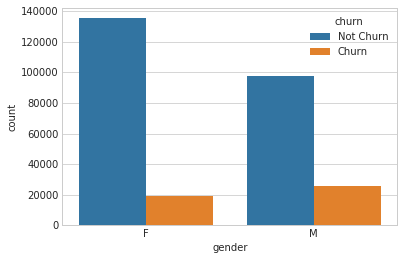

In [28]:
sns.countplot(x="gender", hue="churn", data=pd_gender);

In [29]:
pd_level = df_churn.select(["userId", "level", "churn"]).withColumn("churn", func_churn_label("churn")).toPandas()
pd_level.head()

,userId,level,churn
0,100010,free,Not Churn
1,100010,free,Not Churn
2,100010,free,Not Churn
3,100010,free,Not Churn
4,100010,free,Not Churn


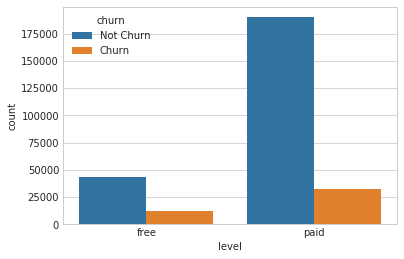

In [30]:
sns.countplot(x="level", hue="churn", data=pd_level);

In [31]:
pd_artist = df_churn_user.join(df_churn.groupby("userId") \
                                    .agg({"artist": "count"}) \
                                    .withColumnRenamed("count(artist)", "artist_count"), ["userId"]) \
                         .withColumn("churn", func_churn_label("churn")).toPandas()
pd_artist.head()

,userId,churn,artist_count
0,100010,Not Churn,275
1,200002,Not Churn,387
2,125,Churn,8
3,124,Not Churn,4079
4,51,Churn,2111


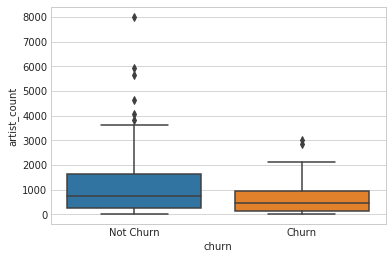

In [32]:
sns.boxplot(x="churn", y="artist_count", data=pd_artist);

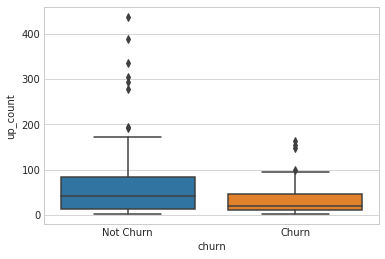

In [33]:
pd_up = df_churn_user.join(df_churn.filter((df_churn["page"] == 'Thumbs Up')) \
                                   .groupby("userId") \
                                   .count() \
                                   .withColumnRenamed("count", "up_count"), ["userId"]) \
                     .withColumn("churn", func_churn_label("churn")).toPandas()
pd_up.head()
sns.boxplot(x="churn", y="up_count", data=pd_up);

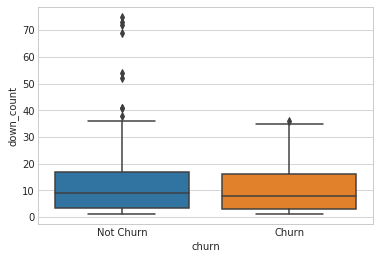

In [34]:
pd_down = df_churn_user.join(df_churn.filter((df_churn["page"] == 'Thumbs Down')) \
                                   .groupby("userId") \
                                   .count() \
                                   .withColumnRenamed("count", "down_count"), ["userId"]) \
                     .withColumn("churn", func_churn_label("churn")).toPandas()
pd_down.head()
sns.boxplot(x="churn", y="down_count", data=pd_down);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [35]:
def feature_engineering(df):
    """
    A function to build the dataframe for modelling.
    
    The input is the cleaned dataset,df, with the target variable, the churn ratio.
    """
    
    df_original = df.groupby('userId').max("churn").withColumnRenamed("max(churn)", "target")
    user_artist = df.groupby("userId").agg({"artist": "count"}).withColumnRenamed("count(artist)", "artist_count")
    
    flag_gender = udf(lambda x: 1 if x == "F" else 0, IntegerType())
    df_churn_with_gender = df.withColumn("gender", flag_gender("gender"))    
    user_gender = df_churn_with_gender.groupby('userId').agg({"gender": "max"}).withColumnRenamed("max(gender)", "gender")
    
    user_thumbs_up = df.filter(df["page"] == 'Thumbs Up').groupby('userId').count().withColumnRenamed("count", "thumb_up")
    user_thumbs_down = df.filter(df["page"] == 'Thumbs Down').groupby('userId').count().withColumnRenamed("count", "thumb_down")
    
    flag_level = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
    df_churn_with_level = df.withColumn("level", flag_level("level"))
    user_level = df_churn_with_level.groupby('userId').agg({"level": "max"}).withColumnRenamed("max(level)", "level")
    
    user_length = df.groupby('userId').agg({"length": "sum"}).withColumnRenamed("sum(length)", "length")
    
    user_song = df.groupby("userId").agg({"song": "count"}).withColumnRenamed("count(song)", "song_count")
    
    merged_df = df_original.join(user_artist, ['userId']) \
    .join(user_gender, ['userId']) \
    .join(user_length, ['userId']) \
    .join(user_level, ['userId']) \
    .join(user_thumbs_up, ['userId']) \
    .join(user_thumbs_down, ['userId']) \
    .join(user_song, ['userId'])
    
    return merged_df



In [36]:
merged_df=feature_engineering(df_churn)

In [37]:
merged_df.head(5)

[Row(userId='100010', target=0, artist_count=275, gender=1, length=66940.89735000003, level=0, thumb_up=17, thumb_down=5, song_count=275),
 Row(userId='200002', target=0, artist_count=387, gender=0, length=94008.87593999993, level=1, thumb_up=21, thumb_down=6, song_count=387),
 Row(userId='124', target=0, artist_count=4079, gender=1, length=1012312.0927899999, level=1, thumb_up=171, thumb_down=41, song_count=4079),
 Row(userId='51', target=1, artist_count=2111, gender=0, length=523275.8428000004, level=1, thumb_up=100, thumb_down=21, song_count=2111),
 Row(userId='7', target=0, artist_count=150, gender=0, length=38034.08710000002, level=0, thumb_up=7, thumb_down=1, song_count=150)]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [38]:
X = merged_df.drop("userId")
feature_columns = [col for col in X.columns if col!='target']
feature_columns

['artist_count',
 'gender',
 'length',
 'level',
 'thumb_up',
 'thumb_down',
 'song_count']

In [40]:
X_train, X_test = X.randomSplit([0.7, 0.3], seed=0)

In [41]:
def build_model(classifier, param):
    
    """
    Function to build the model, comprises the pipeline with vectorization,scale and classifier.
    
    Inputs:
    
    classifier: Model we want to fit.
    param: Hyperparameters we want to try.
    
    Outputs:
    model
    
    """
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='target', metricName='f1'),
        numFolds=5,
    )
    return model

In [42]:
def model(classifier,param,train_set):
    """
    Function fit the model, calling to the build model function.
    
    Inputs:
    
    classifier: Model we want to fit.
    param: Hyperparameters we want to try.
    train_set: 
    
    Outputs:
    fitted model
    
    """
    model=classifier(featuresCol="scaled_features",labelCol="target")
    model = build_model(model, param)
    fit_model = model.fit(train_set)
    return fit_model
    


In [43]:
def evaluator(model,test_set):
     """
    Function to evaluate the model.
    
    Inputs:
    
    model: Fitted model we want to evaluate.
    test_set: Part of the data to test the model.
    
    Outputs:
    Metrics: acc,f1...
    
    """
    
    # Create both evaluators
    evaluatorMulti = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction")
    evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction", metricName='areaUnderROC')

    # Make predicitons
    predictionAndTarget = model.transform(test_set)
    predictionAndTarget.select("prediction").dropDuplicates().collect()

    # Get metrics
    acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
    f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
    weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
    weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
    auc = evaluator.evaluate(predictionAndTarget)

    print("acc: {}".format(acc))
    print("f1: {}".format(f1))
    print("weightedPrecision: {}".format(weightedPrecision))
    print("weightedRecall: {}".format(weightedRecall))
    print("auc: {}".format(auc))


In [44]:
def feature_importance(fit_model):
     """
    Function to plot the feature importance.
    
    Inputs:
    
    model: Fitted model we want to evaluate.
    
    
    Outputs:
    Graph
    
    """
    df = pd.DataFrame()
    df['feature'] = feature_columns
    df['importance'] = fit_model.bestModel.stages[2].featureImportances.values.tolist()
    df =df.sort_values(by='importance', ascending=False).reset_index(drop=True)
    
    plt.figure(figsize=(7,7))
    sns.barplot(x='importance', y='feature', data=df, color="b")
    plt.title('Feature Importance')
    plt.ylabel('');

In [44]:
classifier=LogisticRegression
# param grid for logistic regression
paramGrid_lr = ParamGridBuilder()\
    .addGrid(classifier.maxIter, [10, 20]) \
    .addGrid(classifier.elasticNetParam, [0, 0.5]) \
    .addGrid(classifier.regParam,[0.1, 1]) \
    .build()

lr=model(classifier,paramGrid_lr,X_train)


In [45]:
evaluator(lr,X_test)

acc: 0.8153846153846154
f1: 0.7324641460234681
weightedPrecision: 0.6648520710059171
weightedRecall: 0.8153846153846154
auc: 0.5


In [45]:
classifier=RandomForestClassifier
paramGrid_rf = ParamGridBuilder() \
    .addGrid(classifier.maxDepth,[3, 10]) \
    .addGrid(classifier.minInstancesPerNode, [20, 30]) \
    .addGrid(classifier.subsamplingRate, [0.7, 1.0]) \
    .build()
rf=model(classifier, paramGrid_rf,X_train)


In [46]:
evaluator(rf,X_test)

acc: 0.8
f1: 0.7478260869565218
weightedPrecision: 0.7322580645161291
weightedRecall: 0.8
auc: 0.5227987421383649


In [48]:
classifier=GBTClassifier
# param grid for gbtc

paramGrid_gbtc = ParamGridBuilder()\
            .addGrid(classifier.maxIter, [5,10,20])\
            .addGrid(classifier.maxDepth, [2, 5])\
            .addGrid(classifier.maxBins, [32, 64])\
            .build()
gbt=model(classifier,paramGrid_gbtc,X_train)


In [49]:
evaluator(gbt,X_test)

acc: 0.6923076923076923
f1: 0.7215309200603317
weightedPrecision: 0.7793137095462678
weightedRecall: 0.6923076923076923
auc: 0.6501572327044027


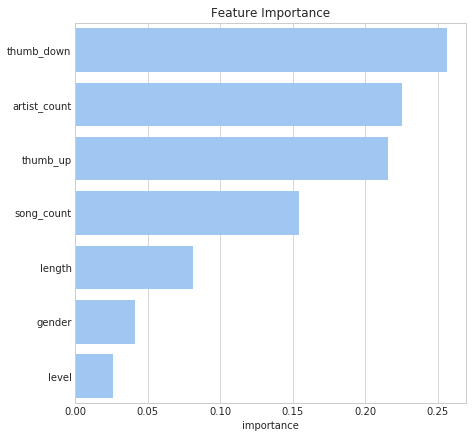

In [47]:
feature_importance(rf)

In [49]:
best_model = rf.bestModel

best_model.stages[2].write().overwrite().save("rf")


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.